<h1 align="center" style="font-variant: small-caps">Tutorial: basic model manipulations with <strong>GBApy</strong></h1>
<h5 align="center">(<code>Version 2</code>, February 2025)</h5>

<div align="center" style="max-width:100px;display:block;margin:auto;">

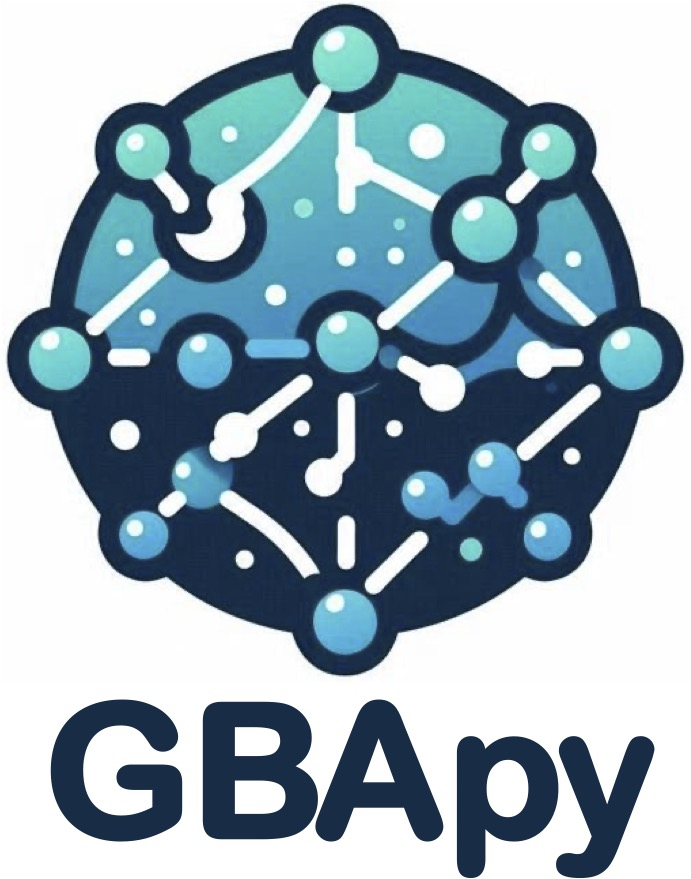

</div>

<strong>GBApy</strong> provides a class to manipulate GBA models: the class `GbaModel`. After loading the model from CSV or binary format (see tutorial `convert_csv_to_gba_tutorial.ipynb`), various algorithms are available to calculate initial, random or optimal solutions, or to simulate evolution.

#### Note:
This tutorial requires the Python module `plotly`.

# Table of content

* [1. Load the model "A" from CSV files](#load)
* [2. Calculate valid solutions](#solutions)
  * [2.1. Find one initial solution](#solutions_1)
  * [2.2. Generate a set of random initial solutions](#solutions_2)
  * [2.3. Calculate an optimal solution for each condition](#solutions_3)
* [3. Run evolutionary simulations](#simulations)
  * [3.1. Run a gradient ascent](#GA)
  * [3.2. Run a Monte Carlo simulation](#MC)
  * [3.3. Run a Markov Chain Monte Carlo simulation](#MCMC)
* [4. Plot evolutionary trajectories](#trajectories)

In [1]:
import os
import sys
import gba
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Load the model "A" from CSV files <a name="load"></a>

In [2]:
model = gba.read_toy_model("A")

❯ Info,KM backward constants not loaded.


❯ Info,KA constants not loaded.


❯ Info,KI constants not loaded.


❯ Info,Constant RHS terms not loaded.


❯ Info,Constant reactions not loaded.


❯ Info,Protein contributions not loaded.


❯ Info,LP solution not loaded.


# 2. Calculate valid solutions <a name="solutions"></a>

<strong>GBApy</strong> provides method to calculate various valid GBA solutions (<em>i.e.</em> $f$ vector solutions).

## 2.1. Find one initial solution <a name="solution_1"></a>

Most GBA optimization algorithms require at least one initial valid solution in the solution space of $f$. A linear program (LP) routine is available in <strong>GBApy</strong> to generate this initial point: `gba.GbaModel.solve_local_linear_problem()`. The solution is stored in the attribute `gba.GbaModel.LP_solution`:

In [3]:
help(model.solve_local_linear_problem)

Help on method solve_local_linear_problem in module gba.GbaModel:

solve_local_linear_problem(max_flux_fraction: Optional[float] = 10.0, rhs_factor: Optional[float] = 10.0) -> None method of gba.GbaModel.GbaModel instance
    Solve the local linear problem to find the initial solution.

    Description
    -----------
    The local linear problem consists in finding the maximal ribosome
    flux fraction f^r, with a minimal production of each metabolite.
    The constraints are mass conservation (M*f = b) and surface flux
    balance (sM*f = 1).

    Parameters
    ----------
    max_flux_fraction : Optional[float], default=10.0
        Maximal flux fraction.
    rhs_factor : Optional[float], default=100.0
        Factor dividing the rhs of the mass conservation constraint.



In [4]:
model.solve_local_linear_problem()
model.LP_solution

array([1.  , 0.95])

## 2.2. Generate a set of random initial solutions <a name="solution_2"></a>

The user might want to generate many random initial solutions to explore the solution space of the GBA model. At least three parameters are required:
- The external condition to explore,
- The number os solutions to generate,
- The maximal number of trials.

In [5]:
help(model.generate_random_initial_solutions)

Help on method generate_random_initial_solutions in module gba.GbaModel:

generate_random_initial_solutions(condition_id: str, nb_solutions: int, max_trials: int, max_flux_fraction: Optional[float] = 10.0, min_mu: Optional[float] = 0.001, verbose: Optional[bool] = False) -> None method of gba.GbaModel.GbaModel instance
    Generate random initial solutions.

    Parameters
    ----------
    condition_id : str
        Condition identifier.
    nb_solutions : int
        Number of solutions to generate.
    max_trials : int
        Maximum number of trials.
    max_flux_fraction : Optional[float], default=10.0
        Maximal flux fraction.
    min_mu : Optional[float], default=1e-3
        Minimal growth rate.
    verbose : Optional[bool], default=False
        Verbose mode.



In [6]:
model.generate_random_initial_solutions(condition_id="1", nb_solutions=10, max_trials=10000, verbose=True)

❯ 1 solutions were found after 4 trials (last mu = 2.08216).

❯ 2 solutions were found after 44 trials (last mu = 1.19036).

❯ 3 solutions were found after 47 trials (last mu = 0.66425).

❯ 4 solutions were found after 55 trials (last mu = 1.69561).

❯ 5 solutions were found after 76 trials (last mu = 2.58249).

❯ 6 solutions were found after 110 trials (last mu = 2.57431).

❯ 7 solutions were found after 113 trials (last mu = 2.58792).

❯ 8 solutions were found after 119 trials (last mu = 1.33879).

❯ 9 solutions were found after 120 trials (last mu = 1.84561).

❯ 10 solutions were found after 134 trials (last mu = 2.56271).

In [7]:
model.random_data

,condition,mu,density,rxn1,Ribosome
0,1,2.082164,1.0,1.0,0.401552
1,1,1.19036,1.0,1.0,0.164527
2,1,0.66425,1.0,1.0,0.078915
3,1,1.695605,1.0,1.0,0.278588
4,1,2.582487,1.0,1.0,0.66752
5,1,2.574308,1.0,1.0,0.906242
6,1,2.587921,1.0,1.0,0.672142
7,1,1.338791,1.0,1.0,0.194042
8,1,1.84561,1.0,1.0,0.321514
9,1,2.562709,1.0,1.0,0.65145


## 2.3. Calculate an optimal solution for each condition <a name="solution_3"></a>

A routine is available to calculate the optimal solution that maximizes the growth rate for each external condition. Note that a full column rank model is prefered at this stage to ensure the convexity of the problem, and the unicity of the solution.

In [8]:
help(model.compute_optima)

Help on method compute_optima in module gba.GbaModel:

compute_optima(max_time: Optional[int] = 10, initial_dt: Optional[float] = 0.01, verbose: Optional[bool] = False) -> float method of gba.GbaModel.GbaModel instance
    Compute the optima by gradient ascent for all conditions.

    Parameters
    ----------
    max_time : Optional[int], default=10
        Maximum time for the algorithm.
    initial_dt : Optional[float], default=0.01
        Initial time step.
    verbose : Optional[bool], default=False
        Verbose mode.

    Returns
    -------
    float
        Run time.



In [9]:
run_time = model.compute_optima(verbose=True)

❯ All optima were computed in 0.5474660396575928 seconds.

In [10]:
model.optima_data

,condition,mu,density,converged,run_time,f_rxn1,f_Ribosome
0,1,2.683106,1.0,1,0.029883,1.0,0.812691
1,2,2.678685,1.0,1,0.024385,1.0,0.813067
2,3,2.672085,1.0,1,0.02125,1.0,0.813625
3,4,2.662254,1.0,1,0.021043,1.0,0.814454
4,5,2.64766,1.0,1,0.020534,1.0,0.815674
5,6,2.626107,1.0,1,0.020777,1.0,0.817457
6,7,2.59451,1.0,1,0.020027,1.0,0.82003
7,8,2.548687,1.0,1,0.020031,1.0,0.823681
8,9,2.483248,1.0,1,0.02107,1.0,0.828736
9,10,2.391791,1.0,1,0.020473,1.0,0.83552


# 3. Run evolutionary simulations <a name="simulations"></a>

<strong>GBApy</strong> provides three different evolutionary algorithms to analyze the evolution of GBA models:
- A gradient ascent algorithm following the growth rate gradient towards an optimum (which could be the mean trajecotry of an infinite population with overlapping generations),
- A Monte Carlo algorithm, which simulates the evolution of a mean population of size $N_e$ undergoing genetic drift,
- A Markov Chain Monte Carlo algorithm, which simulates the fixation of new mutations in a population of size $N_e$ through generation time.

It is necessary to initialize the simulation by providing an initial point (here, the LP solution presented above). We also want to track trajectories (option `track=True`).

## 3.1. Run a gradient ascent <a name="GA"></a>

In [11]:
help(model.gradient_ascent)

Help on method gradient_ascent in module gba.GbaModel:

gradient_ascent(condition_id: Optional[str] = '1', max_time: Optional[float] = 10.0, initial_dt: Optional[float] = 0.01, track: Optional[bool] = False, variables: Optional[list[str]] = ['f'], label: Optional[int] = 1, verbose: Optional[bool] = False, print_period: Optional[int] = 0) -> tuple[bool, float] method of gba.GbaModel.GbaModel instance
    Run a gradient ascent algorithm to find the optimal flux state.

    Parameters
    ----------
    condition_id : str, default="1"
        Condition identifier.
    max_time : float, default=10.0
        Maximum time for the algorithm.
    initial_dt : float, default=0.01
        Initial time step.
    track : bool, default=False
        Track the trajectory of variables.
    variables : list[str], default=["f"]
        Additional variables to track.
    label : int, default=1
        Label for the trajectory.
    verbose : bool, default=False
        Verbose mode.
    print_period : in

In [12]:
model.set_f0(model.LP_solution)
model.clear_gradient_ascent_trajectory()
res = model.gradient_ascent(condition_id="1", initial_dt=0.0001, track=True, verbose=True)

❯ Gradient ascent: convergence reached (condition=1, mu=2.68311, nb iterations=695, nb fixed=684).

In [13]:
model.GA_tracker

,label,condition,iter,dt,t,mu,fixed,f_rxn1,f_Ribosome
0,1,1,0,0.0001,0.0,2.307335,0,1.0,0.95
1,1,1,1,0.0001,0.0001,2.318857,1,1.0,0.948917
2,1,1,2,0.0001,0.0002,2.3296,2,1.0,0.947872
3,1,1,3,0.0001,0.0003,2.339648,3,1.0,0.946861
4,1,1,4,0.0001,0.0004,2.349074,4,1.0,0.945883
...,...,...,...,...,...,...,...,...,...
680,1,1,690,0.0,1.085168,2.683106,680,1.0,0.812691
681,1,1,691,0.0,1.085168,2.683106,681,1.0,0.812691
682,1,1,692,0.0,1.085168,2.683106,682,1.0,0.812691
683,1,1,693,0.0,1.085168,2.683106,683,1.0,0.812691


## 3.2. Run a Monte Carlo simulation <a name="MC"></a>


In [14]:
help(model.MC_simulation)

Help on method MC_simulation in module gba.GbaModel:

MC_simulation(condition_id: Optional[str] = '1', max_time: Optional[float] = 10.0, max_iterations: Optional[int] = 100000, sigma: Optional[float] = 0.1, N_e: Optional[float] = 25000000.0, track: Optional[bool] = False, variables: Optional[list[str]] = ['f'], label: Optional[int] = 1, verbose: Optional[bool] = False, print_period: Optional[int] = 0) -> tuple[bool, float] method of gba.GbaModel.GbaModel instance
    Run a Monte Carlo simulation with genetic drift.

    Notes
    -----
    The algorithm is based on the Pál & Miklós (1999) model.
    f(t+1) = f(t) + sigma * dmu/df + epsilon.

    Parameters
    ----------
    condition_id : Optional[str], default="1"
        Condition identifier.
    max_time : Optional[float], default=10.0
        Maximum time for the algorithm.
    max_iterations : Optional[int], default=100000
        Maximum number of iterations.
    sigma : Optional[float], default=0.1
        Standard deviation of

In [15]:
model.set_f0(model.LP_solution)
model.clear_MC_trajectory()
res = model.MC_simulation(condition_id="1", sigma=0.01, N_e=10, max_time=200, track=True, verbose=True)

❯ MC simulation completed (condition 1 , mu = 2.67098, nb iterations = 200, nb fixed = 200).

In [16]:
model.MC_tracker

,label,condition,t,mu,fixed,f_rxn1,f_Ribosome
0,1,1,0.0,2.307335,0,1.0,0.95
1,1,1,1.0,2.669941,1,1.0,0.851655
2,1,1,2.0,2.651124,2,1.0,0.870299
3,1,1,3.0,2.654326,3,1.0,0.867759
4,1,1,4.0,2.618019,4,1.0,0.889778
...,...,...,...,...,...,...,...
196,1,1,196.0,2.680595,196,1.0,0.830613
197,1,1,197.0,2.683105,197,1.0,0.812278
198,1,1,198.0,2.681482,198,1.0,0.827216
199,1,1,199.0,2.681924,199,1.0,0.82514


## 3.3. Run a Markov Chain Monte Carlo simulation <a name="MCMC"></a>


In [17]:
help(model.MCMC_simulation)

Help on method MCMC_simulation in module gba.GbaModel:

MCMC_simulation(condition_id: Optional[str] = '1', max_iterations: Optional[int] = 100000, sigma: Optional[float] = 0.1, N_e: Optional[float] = 25000000.0, track: Optional[bool] = False, variables: Optional[list[str]] = ['f'], label: Optional[int] = 1, verbose: Optional[bool] = False, print_period: Optional[int] = 0) -> tuple[bool, float] method of gba.GbaModel.GbaModel instance
    Run a Markov Monte Carlo simulation with genetic drift.

    Notes
    -----
    The algorithm is based on the standard MCMC formulation (Gillespie, 1983).

    Parameters
    ----------
    condition_id : Optional[str], default="1"
        Condition identifier.
    max_iterations : Optional[int], default=100000
        Maximum number of iterations.
    sigma : Optional[float], default=0.1
        Standard deviation of the noise.
    N_e : Optional[float], default=2.5e7
        Effective population size.
    track : Optional[bool], default=False
      

In [18]:
model.set_f0(model.LP_solution)
model.clear_MCMC_trajectory()
res = model.MCMC_simulation(condition_id="1", sigma=0.02, max_iterations=10000, track=True, verbose=True)

❯ MCMC simulation: maximum iterations reached (condition=1, mu=2.68308, nb iterations=10000, nb fixed=7).

In [19]:
model.MCMC_tracker

,label,condition,t,mu,fixed,f_rxn1,f_Ribosome
0,1,1,0.0,2.307335,0,1.0,0.95
1,1,1,16,2.429619,1,1.0,0.936058
2,1,1,25,2.47927,2,1.0,0.928229
3,1,1,82,2.559793,3,1.0,0.910503
4,1,1,156,2.656333,4,1.0,0.866069
5,1,1,235,2.675193,5,1.0,0.843538
6,1,1,1084,2.681552,6,1.0,0.826909
7,1,1,4560,2.683077,7,1.0,0.8107


# 4. Plot evolutionary trajectories <a name="trajectories"></a>

We will now plot and compare the trajectories using the Python module `plotly`. <strong>GBApy</strong> provides a useful trajectory getter to extract vectors: `gba.GbaModel.get_trajectory(algorithm, variable)`.

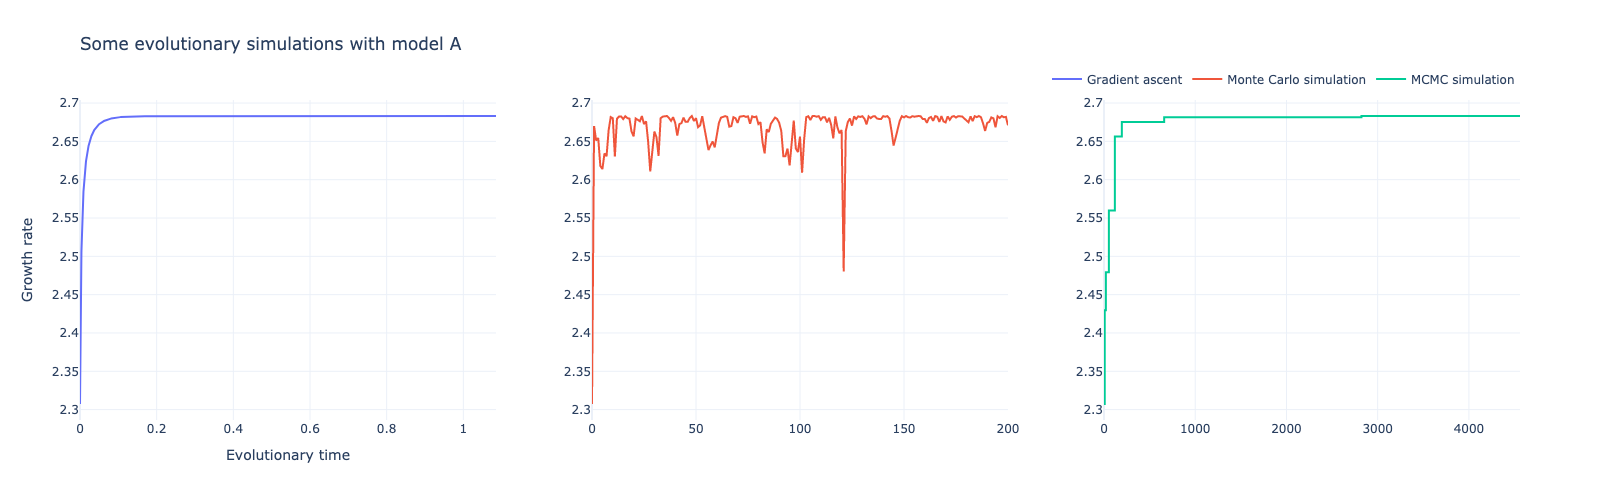

In [20]:
#fig = go.Figure()
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Scatter(x=model.get_vector("GA", "t"), y=model.get_vector("GA", "mu"), name="Gradient ascent", mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(x=model.get_vector("MC", "t"), y=model.get_vector("MC", "mu"), name="Monte Carlo simulation", mode="lines"), row=1, col=2)
fig.add_trace(go.Scatter(x=model.get_vector("MCMC", "t"), y=model.get_vector("MCMC", "mu"), name="MCMC simulation", mode="lines", line=dict(shape='hvh')), row=1, col=3)
fig.update_layout(barmode='relative',  plot_bgcolor='white', template="plotly_white", title=dict(text="Some evolutionary simulations with model A"))
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
), xaxis_title="Evolutionary time", yaxis_title="Growth rate")
fig.update_layout(height=500, width=1600)
fig.show("png")